In [33]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [34]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_VAR.csv', converters={'ags2': str, 'ags5': str} )
df = df[df['ags5'].apply(lambda x: x.startswith('09'))]
df

,date,ground_truth,pred,ags5
5328,2018-01-01,3.2,3.253616,09161
5329,2018-02-01,3.2,3.282570,09161
5330,2018-03-01,3.1,3.111190,09161
5331,2018-04-01,2.9,3.010143,09161
5332,2018-05-01,2.9,2.942032,09161
...,...,...,...,...
7627,2019-08-01,2.1,2.031868,09780
7628,2019-09-01,2.0,2.012269,09780
7629,2019-10-01,1.9,1.905699,09780
7630,2019-11-01,2.5,2.456377,09780


In [35]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [36]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis
0,2018-01-01,3.2,3.253616,09161,09,Freistaat Bayern,Ingolstadt
1,2018-02-01,3.2,3.282570,09161,09,Freistaat Bayern,Ingolstadt
2,2018-03-01,3.1,3.111190,09161,09,Freistaat Bayern,Ingolstadt
3,2018-04-01,2.9,3.010143,09161,09,Freistaat Bayern,Ingolstadt
4,2018-05-01,2.9,2.942032,09161,09,Freistaat Bayern,Ingolstadt
...,...,...,...,...,...,...,...
2299,2019-08-01,2.1,2.031868,09780,09,Freistaat Bayern,Oberallgäu
2300,2019-09-01,2.0,2.012269,09780,09,Freistaat Bayern,Oberallgäu
2301,2019-10-01,1.9,1.905699,09780,09,Freistaat Bayern,Oberallgäu
2302,2019-11-01,2.5,2.456377,09780,09,Freistaat Bayern,Oberallgäu


In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [39]:
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
0,2018-01-01,3.2,3.253616,09161,09,Freistaat Bayern,Ingolstadt,1.675511
1,2018-02-01,3.2,3.282570,09161,09,Freistaat Bayern,Ingolstadt,2.580313
2,2018-03-01,3.1,3.111190,09161,09,Freistaat Bayern,Ingolstadt,0.360983
3,2018-04-01,2.9,3.010143,09161,09,Freistaat Bayern,Ingolstadt,3.798042
4,2018-05-01,2.9,2.942032,09161,09,Freistaat Bayern,Ingolstadt,1.449383
...,...,...,...,...,...,...,...,...
2299,2019-08-01,2.1,2.031868,09780,09,Freistaat Bayern,Oberallgäu,3.244403
2300,2019-09-01,2.0,2.012269,09780,09,Freistaat Bayern,Oberallgäu,0.613475
2301,2019-10-01,1.9,1.905699,09780,09,Freistaat Bayern,Oberallgäu,0.299970
2302,2019-11-01,2.5,2.456377,09780,09,Freistaat Bayern,Oberallgäu,1.744907


In [40]:
#df.to_csv('./MAPE_errors_2018_2019.csv', index = False)

## Plot each variable

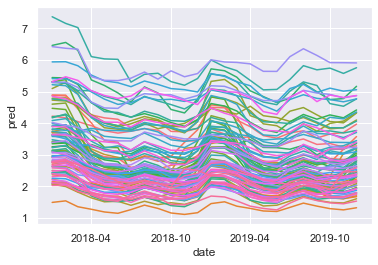

In [41]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

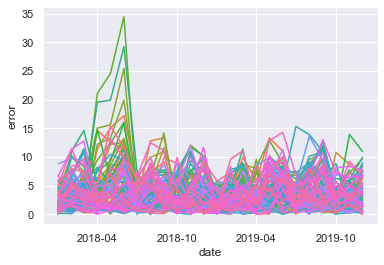

In [42]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

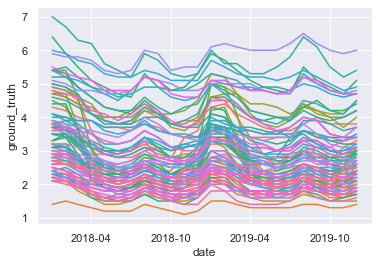

In [43]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

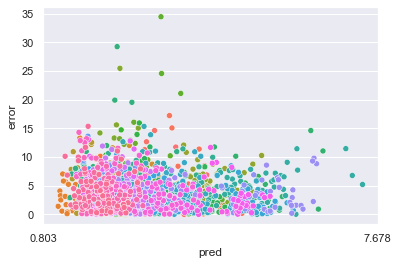

In [44]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [45]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [46]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

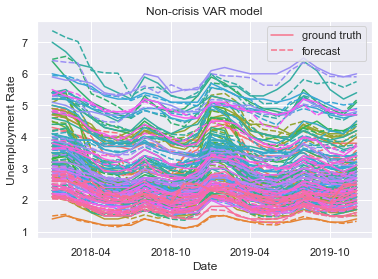

In [47]:
g = sns.lineplot(data=df_long, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set(xlabel='Date', ylabel='Unemployment Rate')
g.set_title('Non-crisis VAR model')
plt.legend(loc='upper right', labels=['ground truth', 'forecast'])
#plt.savefig('sample_ur_VAR_normal.png')

## Look into mean errors

In [48]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09161,09,Freistaat Bayern,Ingolstadt,2.950000,2.962940,2.300814
09162,09,Freistaat Bayern,München,3.625000,3.617925,1.828276
09163,09,Freistaat Bayern,Rosenheim,4.000000,4.025828,3.446021
09171,09,Freistaat Bayern,Altötting,2.858333,2.891527,4.387897
09172,09,Freistaat Bayern,Berchtesgadener Land,3.433333,3.514622,4.612200
...,...,...,...,...,...,...
09776,09,Freistaat Bayern,Lindau (Bodensee),2.354167,2.344426,3.897702
09777,09,Freistaat Bayern,Ostallgäu,2.183333,2.180165,2.828380
09778,09,Freistaat Bayern,Unterallgäu,1.808333,1.776954,3.076580


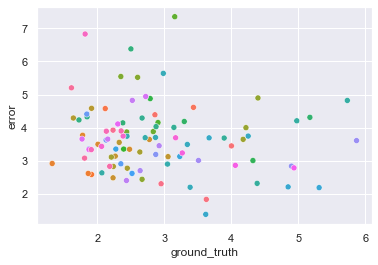

In [49]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

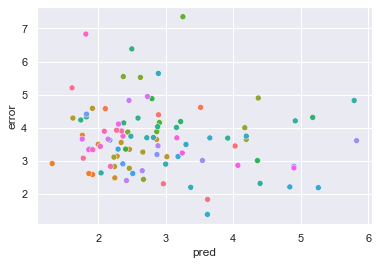

In [50]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [51]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09276,09,Freistaat Bayern,Regen,3.154167,3.252799,7.354732
09773,09,Freistaat Bayern,Dillingen a.d.Donau,1.816667,1.815872,6.830677
09372,09,Freistaat Bayern,Cham,2.500000,2.496244,6.380346
09476,09,Freistaat Bayern,Kronach,2.983333,2.889236,5.640615
09273,09,Freistaat Bayern,Kelheim,2.350000,2.369708,5.545130
...,...,...,...,...,...,...
09563,09,Freistaat Bayern,Fürth,4.845833,4.835790,2.206570
09477,09,Freistaat Bayern,Kulmbach,3.383333,3.368430,2.195272
09564,09,Freistaat Bayern,Nürnberg,5.308333,5.257844,2.184387


<AxesSubplot:xlabel='error', ylabel='Density'>

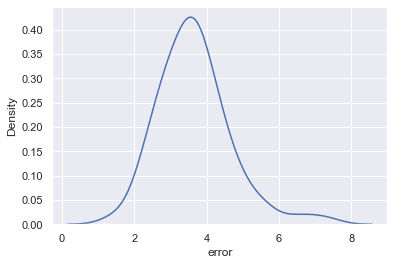

In [52]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [53]:
df.sort_values(by = ['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
749,2018-06-01,2.4,3.226777,09276,09,Freistaat Bayern,Regen,34.449025
941,2018-06-01,1.8,2.326327,09372,09,Freistaat Bayern,Cham,29.240414
653,2018-06-01,1.9,2.383714,09272,09,Freistaat Bayern,Freyung-Grafenau,25.458624
748,2018-05-01,2.6,3.238524,09276,09,Freistaat Bayern,Regen,24.558605
747,2018-04-01,3.0,3.632701,09276,09,Freistaat Bayern,Regen,21.090017
...,...,...,...,...,...,...,...,...
541,2019-02-01,2.5,2.500316,09190,09,Freistaat Bayern,Weilheim-Schongau,0.012625
72,2018-01-01,3.7,3.700441,09171,09,Freistaat Bayern,Altötting,0.011915
2007,2019-04-01,4.0,3.999556,09762,09,Freistaat Bayern,Kaufbeuren,0.011102
487,2018-08-01,2.5,2.500060,09188,09,Freistaat Bayern,Starnberg,0.002383


In [54]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

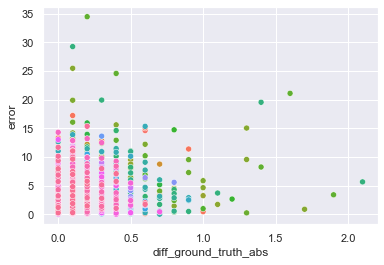

In [55]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

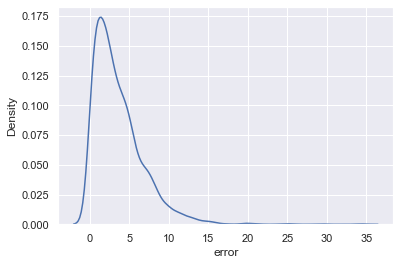

In [56]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

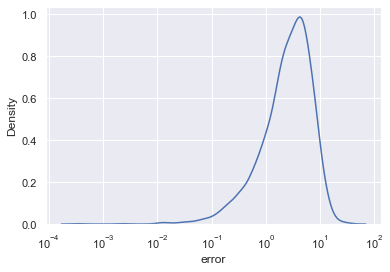

In [57]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [58]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


In [59]:
df_structural[df_structural['kreis'] == 'Stuttgart']

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
178,2,Stuttgart,08111,08,96,403,68,302,1442,265,...,1,1,1,urban,9,5,west,0,N,not_eligible_area


### Merge to df with mean errors

In [60]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [61]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    p = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    p.set_title('MAPE non-crisis VAR model')
    #plt.savefig(f'{column_name}_MAPE_non_crisis.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

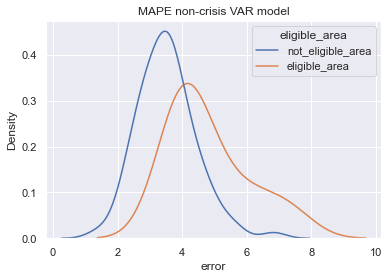

Ttest_indResult(statistic=-3.228897483915683, pvalue=0.008863243640704035)

In [62]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

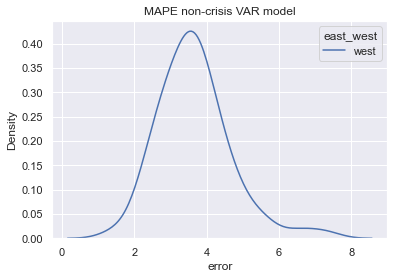

ValueError: not enough values to unpack (expected 2, got 1)

In [63]:
compare_error_in_two_groups(df_mixed, 'east_west')

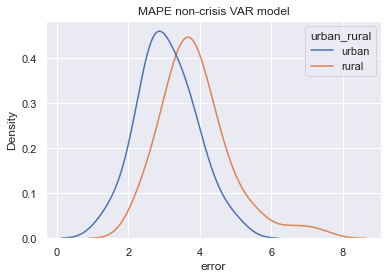

Ttest_indResult(statistic=-4.114196161739206, pvalue=0.00012213770194486419)

In [64]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [65]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

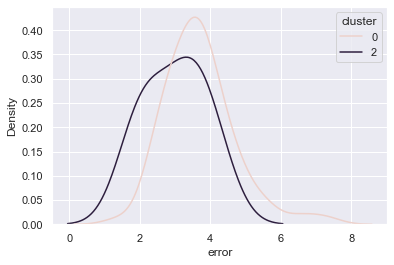

             sum_sq    df        F    PR(>F)
cluster    2.796170   1.0  2.77302  0.099195
Residual  94.784715  94.0      NaN       NaN


In [66]:
compare_error_in_two_groups(df_mixed, "cluster")

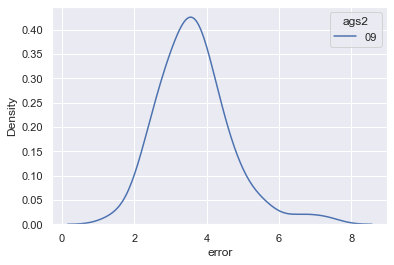

ValueError: must have at least one row in constraint matrix

In [67]:
compare_error_in_two_groups(df_mixed, "ags2")

In [ ]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

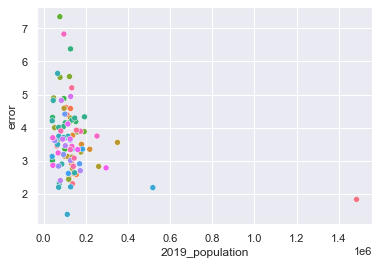

In [68]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [69]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [70]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [71]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [72]:
stats.summary(regr, X, Y, X.columns)

LinAlgError: Singular matrix

### Sequential Feature Selector

In [73]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [74]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(164,)","[0.23717153465544794, 0.27100440934471015, 0.1...",0.123901,"(room_type_location,)",0.238114,0.185261,0.09263
2,"(30, 164)","[0.36431263278627535, 0.1293316213197654, 0.10...",0.168164,"(share_of_motorised_vehicle_driver, room_type_...",0.197259,0.153474,0.076737
3,"(30, 66, 164)","[0.3004576087006411, 0.22636360419255852, 0.25...",0.223692,"(share_of_motorised_vehicle_driver, proportion...",0.240868,0.187404,0.093702
4,"(30, 66, 132, 164)","[0.3500328030291119, 0.24956639864525354, 0.29...",0.253827,"(share_of_motorised_vehicle_driver, proportion...",0.224589,0.174738,0.087369
5,"(30, 66, 132, 137, 164)","[0.36758243053784456, 0.405923090608857, 0.306...",0.282474,"(share_of_motorised_vehicle_driver, proportion...",0.260373,0.202579,0.10129
6,"(30, 66, 132, 137, 164, 169)","[0.3958075459725011, 0.4427672648235853, 0.286...",0.301274,"(share_of_motorised_vehicle_driver, proportion...",0.23148,0.1801,0.09005
7,"(30, 66, 132, 137, 149, 164, 169)","[0.41430370101777736, 0.4666598527226056, 0.25...",0.318987,"(share_of_motorised_vehicle_driver, proportion...",0.224323,0.174531,0.087265
8,"(30, 35, 66, 132, 137, 149, 164, 169)","[0.5438033226717609, 0.49366616548583386, 0.15...",0.337045,"(share_of_motorised_vehicle_driver, municipal_...",0.316584,0.246313,0.123157
9,"(30, 35, 66, 132, 137, 149, 153, 164, 169)","[0.5439973182655389, 0.5113708446419727, 0.161...",0.347336,"(share_of_motorised_vehicle_driver, municipal_...",0.33103,0.257553,0.128776
10,"(30, 35, 66, 132, 137, 149, 153, 164, 169, 173)","[0.5419264093895979, 0.5113708446419654, 0.167...",0.349064,"(share_of_motorised_vehicle_driver, municipal_...",0.325006,0.252865,0.126433


In [75]:
list(summary_table_select['feature_names'])[:5]

[('room_type_location',),
 ('share_of_motorised_vehicle_driver', 'room_type_location'),
 ('share_of_motorised_vehicle_driver',
  'proportion_of_foreigners_in_2018',
  'room_type_location'),
 ('share_of_motorised_vehicle_driver',
  'proportion_of_foreigners_in_2018',
  'cemetry_area_percentage',
  'room_type_location'),
 ('share_of_motorised_vehicle_driver',
  'proportion_of_foreigners_in_2018',
  'cemetry_area_percentage',
  'shipping_area_percentage',
  'room_type_location')]

### Ridge

In [76]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

Ridge(alpha=0.5)

In [77]:
stats.summary(rr, X, Y, X.columns)

LinAlgError: Singular matrix

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

In [ ]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
#plt.savefig('Commuters_MAPE.png')

In [ ]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
#plt.savefig('debtor_quota_MAPE.png')

In [ ]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

In [ ]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
#plt.savefig('purchasing_power_MAPE.png')

In [ ]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

In [ ]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()

In [ ]:
g = sns.scatterplot(data=df_mixed, x="standing_water_percentage", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
#plt.savefig('standing_water_percentage_MAPE_non_crisis.png')

In [ ]:
g = sns.scatterplot(data=df_mixed, x="Residential_area_percentage", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
#plt.savefig('Residential_area_percentage_MAPE_non_crisis.png')

In [ ]:
df_mixed['ags2_09'] =  np.where(df_mixed['ags2']=='09', 'Bayren', 'not Bayren')

In [ ]:
compare_error_in_two_groups(df_mixed, 'ags2_09')

In [ ]:
    p = sns.kdeplot(data=df_mixed, x="error", hue='ags2_09',  common_norm=False)
    p.set_title('MAPE non-crisis VAR model')
    #plt.savefig(f'Bayren_MAPE_non_crisis.png')
    plt.show()